## Import Libraries

Env used : env_1

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import seaborn as sns


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Data Preprocessing

In [2]:
df=pd.read_excel("../data/bme_clinical_data.xlsx",sheet_name="BME_Analysis_Data",header=1)
#We need to take only trauma patient data: upto 63 rows and all columns
df=df.iloc[:63,1:] 
#Quantitative Columns


In [3]:
quant_columns=['Age','Lysis at One Hour (%)','Delta OD','Turbidity T to Half Max (s)','T to Half Max (s)','Polym Rate (OD/s)','etoh','Lactate (mmol/L)','ddimer','fibrinogen','bicarb','base',
'Temperature (°C)','Revised Trauma Score','triss','ais','prbc','ffp','platelet','cryo','plt','sat','rr']

for col in quant_columns:
    df[col].fillna(df[col].median(),inplace=True)

#Zero Columns
zero_columns=['airway_type','chesttube','ir','or','or_art','or_ven','Abbreviated Injury Scale Head','ais_face','ais_neck','ais_chest','ais_abd','ais_spine','ais_upper','ais_lower','ais_ext']
for col in zero_columns:
    df[col].fillna(0,inplace=True)

#Categorical Columns
cat_columns=['utox','Hemmorhage','arrest','blood24','mtp','dvt','pe','stroke','mi_new']
for col in cat_columns:
    df[col].fillna(df[col].mode()[0],inplace=True)

#Drop Columns
drop_columns=['Head AIS','Spine AIS','tash','thora','or_finding','injuries','mortality','hemorrhage','ISS']
for col in drop_columns:
    if col in df.columns:
        df=df.drop(col,axis=1)

# Now we need to encode the categorical columns before applying a ml model
# Categorical Variables:
# Assuming all variables are nominal(No particular order in the categories)
# Inj  Mech*	7
# Inj Pattern*	6
encode_list=['Inj Mech','Inj Pattern']
if encode_list in list(df.columns):
    df=pd.get_dummies(df,columns=encode_list)
df=df.astype(float)
rep_dict={'Partial Thromboplastin Time[PTT] (s)':'Partial Thromboplastin Time (s)',
          'Prothrombin Time[PT] (s)':'Prothrombin Time(s)',
          'Injury Severity Score[ISS]':'Injury Severity Score'}
df.rename(columns = rep_dict, inplace = True)
#This will show if we have any columns with NaN/Null values
isn=df.isnull().sum()
for k,v in isn.items():
    if v!=0:
        print(k, v)

In [4]:

X = df.drop('Mortality', axis=1)  # Features
y = df['Mortality']  # Target variable
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
print("Train length",len(X_train))
print("Test length",len(X_test))
#Train=37
#Test=26
#Traintestsplit function randomly splits the data into train and test, without maintaining any particular order

(63, 103)
(63,)
Train length 37
Test length 26


In [5]:
def describe_df(df):
    # print(df.info(),"\n")
    print(sum(df.isnull().sum()),"\n")
    # print(df.head(1))
    # print(df.describe())
describe_df(df)

0 



## Supervised Learning

### 1. Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier  # Example classifier

clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=1)

Accuracy: 0.85
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        19
         1.0       0.80      0.57      0.67         7

    accuracy                           0.85        26
   macro avg       0.83      0.76      0.78        26
weighted avg       0.84      0.85      0.84        26



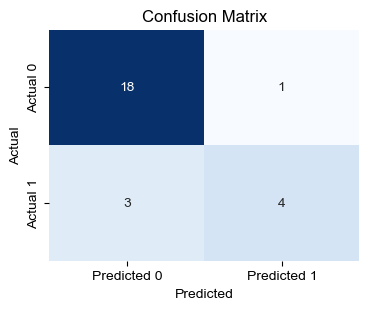

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))
cm=(confusion_matrix(y_test, y_pred))

import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:

# Getting feature importances
feature_importances = clf.feature_importances_

# Matching feature importances with feature names
feature_names = X.columns  # Replacing with the actual feature names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sorting feature importances by importance score
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Printing the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{importance*100:.4f} %\t:\t{feature}")
    # print(f"{feature}: \t\t\t{importance:.4f}")

10.1535 %	:	D'dimer (ng/mL)
8.7486 %	:	Clotting Rate (Pa/s)
6.2421 %	:	Partial Thromboplastin Time (s)
5.2075 %	:	Abbreviated Injury Scale Head
5.0457 %	:	Fibrinogen (mg/mL)
3.8125 %	:	Revised Trauma Score
3.3936 %	:	Max Stiffness (Pa)
3.2724 %	:	Prothrombin Time(s)
2.6086 %	:	Systolic BP (mmHg)
2.5727 %	:	Glasgow Coma Score
2.5698 %	:	Confocal Area (%)
2.4744 %	:	T to Half Max (s)
2.3740 %	:	tPA (pg/mL)
2.2763 %	:	Diastolic BP (mmHg)
1.9922 %	:	Lysis at One Hour (%)
1.8799 %	:	base
1.8427 %	:	sex
1.6821 %	:	Temperature (°C)
1.6605 %	:	Delta OD
1.5362 %	:	Confocal Pore Diameter (μm)
1.4839 %	:	Lag Time (min)
1.4688 %	:	Lactate (mmol/L)
1.2773 %	:	inr
1.2280 %	:	Velocity Index
1.1509 %	:	Injury Severity Score
1.1354 %	:	Turbidity T to Half Max (s)
1.0431 %	:	Age
1.0391 %	:	arrest
1.0317 %	:	hr
1.0056 %	:	airway
0.9943 %	:	hgb
0.9759 %	:	ddimer
0.9130 %	:	Peak Thrombin (nM)
0.8534 %	:	Inj Mech
0.8153 %	:	Fiber length (um)
0.8144 %	:	ais_spine
0.7100 %	:	Time to peak (min)
0.7050 %	:	plt


In [19]:
#Random Forest with hyper parameter
from sklearn.ensemble import RandomForestClassifier  # Example classifier

clf_2 = RandomForestClassifier(
    n_estimators=200,          # Number of trees in the forest
    max_features=20,       # Number of features to consider at each split
    bootstrap=True,            # Whether to use bootstrapped samples
    random_state=1,            # Random seed for reproducibility
    oob_score=True,
    n_jobs=10,
    # verbose=2
)

# Fit the classifier to your training data
clf_2.fit(X_train, y_train)


RandomForestClassifier(max_features=20, n_estimators=200, n_jobs=10,
                       oob_score=True, random_state=1)

#### RF Best

Accuracy: 0.74
              precision    recall  f1-score   support

         0.0       0.73      0.92      0.81        12
         1.0       0.75      0.43      0.55         7

    accuracy                           0.74        19
   macro avg       0.74      0.67      0.68        19
weighted avg       0.74      0.74      0.72        19



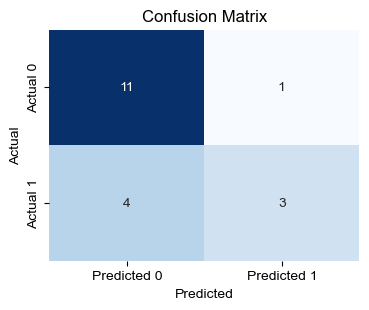

10.3520 %	:	D'dimer (ng/mL)
9.2831 %	:	Fibrinogen (mg/mL)
7.8415 %	:	Partial Thromboplastin Time (s)
7.4042 %	:	Clotting Rate (Pa/s)
5.0939 %	:	Max Stiffness (Pa)
3.9620 %	:	Prothrombin Time(s)
3.4577 %	:	Abbreviated Injury Scale Head
2.7639 %	:	Diastolic BP (mmHg)
2.5569 %	:	Lactate (mmol/L)
2.5562 %	:	Revised Trauma Score
2.5303 %	:	Lysis at One Hour (%)
2.4443 %	:	Temperature (°C)
2.2889 %	:	Confocal Pore Diameter (μm)
2.0753 %	:	Confocal Area (%)
1.8163 %	:	Injury Severity Score
1.7770 %	:	inr
1.7296 %	:	tPA (pg/mL)
1.6675 %	:	hgb
1.6555 %	:	Systolic BP (mmHg)
1.6293 %	:	Velocity Index
1.5628 %	:	T to Half Max (s)
1.4981 %	:	Lag Time (min)
1.1580 %	:	Turbidity T to Half Max (s)
1.0462 %	:	triss
1.0100 %	:	base
0.9143 %	:	Time to peak (min)
0.8670 %	:	Polym Rate (OD/s)
0.8501 %	:	ais_spine
0.7907 %	:	plt
0.7906 %	:	Delta OD
0.7883 %	:	Glasgow Coma Score
0.7650 %	:	ddimer
0.7574 %	:	TBI yes/no
0.7151 %	:	ais_neck
0.7059 %	:	sex
0.6902 %	:	Age
0.6691 %	:	tbi_sci___1
0.6452 %	:	SCI yes

In [20]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_2 = clf_2.predict(X_test)
acc = accuracy_score(y_test, y_pred_2)
print(f'Accuracy: {acc:.2f}')
print(classification_report(y_test, y_pred_2))
cm=(confusion_matrix(y_test, y_pred_2))

import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Getting feature importances
feature_importances_main = clf_2.feature_importances_

# Matching feature importances with feature names
feature_names_main = X.columns  # Replacing with the actual feature names
feature_importance_dict_main = dict(zip(feature_names_main, feature_importances_main))

# Sorting feature importances by importance score
sorted_feature_importances_main = sorted(feature_importance_dict_main.items(), key=lambda x: x[1], reverse=True)

# Printing the sorted feature importances
# s=0
for feature, importance in sorted_feature_importances_main:
    # print(f"{feature}: \t\t\t{importance*100:.4f}")
    # s+=importance
    print(f"{importance*100:.4f} %\t:\t{feature}")
# print(s)

In [21]:
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
# Example of cross-validation
cv_scores = cross_val_score(clf_2, X_train, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Training Data Mean CV Score: {np.mean(cv_scores)}')
test_acc = clf_2.score(X_test, y_test)
print(f'Test Accuracy: {test_acc}')
train_acc = clf_2.score(X_train, y_train)
print(f'Train Accuracy: {train_acc}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### RF with Selected Features

In [22]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Assuming 'clf_2' is your trained RandomForestClassifier
# Create an RFE selector
rfe = RFE(estimator=clf_2, n_features_to_select=20)

# Fit the RFE selector on the training data
rfe.fit(X_train, y_train)

# Transform the training and test data to keep only the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)


In [23]:

# Fit the RandomForestClassifier on the reduced set of features
clf_2_selected = RandomForestClassifier(
    n_estimators=100,
    max_features=2,  # Adjusted to the selected features count
    bootstrap=True,
    random_state=1,
    oob_score=True,
    n_jobs=10
)

clf_2_selected.fit(X_train_selected, y_train)

# Predict on the reduced set of features
y_pred_selected = clf_2_selected.predict(X_test_selected)

# Evaluate the model performance
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f'Test Accuracy with Selected Features: {accuracy_selected:.4f}')
#max_features = 2 , 

Test Accuracy with Selected Features: 0.7895


In [13]:
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
# Example of cross-validation
cv_scores = cross_val_score(clf_2_selected, X_train_selected, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Training Data Mean CV Score: {np.mean(cv_scores)}')
test_acc = clf_2_selected.score(X_test_selected, y_test)
print(f'Test Accuracy: {test_acc}')
train_acc = clf_2_selected.score(X_train_selected, y_train)
print(f'Train Accuracy: {train_acc}')

Cross-Validation Scores: [0.75       0.875      0.85714286 1.         0.85714286]
Training Data Mean CV Score: 0.8678571428571429
Test Accuracy: 0.8461538461538461
Train Accuracy: 1.0


In [14]:
# Get feature importances from the trained RandomForestClassifier
feature_importances_selected = clf_2_selected.feature_importances_

# Create a DataFrame to display feature names and their importances
feature_importance_df_selected = pd.DataFrame({
    'Feature': X_train.columns[rfe.support_],  # Use the original feature names corresponding to the selected features
    'Importance': feature_importances_selected
})

# Sort the DataFrame by feature importance
feature_importance_df_selected = feature_importance_df_selected.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df_selected)


                                 Feature  Importance
12              Prothrombin Time[PT] (s)    0.094760
2                        D'dimer (ng/mL)    0.094665
1                   Clotting Rate (Pa/s)    0.081186
7                     Fibrinogen (mg/mL)    0.077684
11  Partial Thromboplastin Time[PTT] (s)    0.070166
0                     Max Stiffness (Pa)    0.067784
19         Abbreviated Injury Scale Head    0.058674
10                      Lactate (mmol/L)    0.049182
14                   Diastolic BP (mmHg)    0.047360
16                    Glasgow Coma Score    0.046780
13                    Systolic BP (mmHg)    0.046482
6            Confocal Pore Diameter (μm)    0.046404
17                  Revised Trauma Score    0.038969
3            Turbidity T to Half Max (s)    0.038751
15                      Temperature (°C)    0.035471
5                      Confocal Area (%)    0.025839
4                  Lysis at One Hour (%)    0.024177
9                                    hgb    0.

#### RF avoid overfitting

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Original feature selection
num_features = 20
rfe = RFE(estimator=RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=10), n_features_to_select=num_features)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_test_selected = rfe.transform(X_test)

# Updated Random Forest model
clf_rf_updated = RandomForestClassifier(
    n_estimators=100,          # Reduced number of trees
    max_features='sqrt',       # Automatically consider sqrt(number of features) features at each split
    bootstrap=True,
    random_state=1,
    oob_score=True,
    n_jobs=10
)

# Train the updated model on the reduced set of features
clf_rf_updated.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_rf_updated = clf_rf_updated.predict(X_test_selected)


In [49]:
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# # Using StratifiedKFold for maintaining class distribution
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# # Perform cross-validation
# cv_scores = cross_val_score(clf_rf_updated, X, y, cv=cv, scoring='accuracy')

# # Print the cross-validation scores
# print("Cross-Validation Scores:", cv_scores)
# print("Mean CV Score:", np.mean(cv_scores))

In [1]:

# Evaluate the updated model
accuracy_rf_updated = accuracy_score(y_test, y_pred_rf_updated)
print(f'Test Accuracy with Updated Random Forest: {accuracy_rf_updated:.4f}')

# Cross-validation scores with the updated model
cv_scores_rf_updated = cross_val_score(clf_rf_updated, X_train_selected, y_train, cv=5)
print('Cross-Validation Scores:', cv_scores_rf_updated)
print(f'Mean CV Score: {cv_scores_rf_updated.mean()}')

# Confusion matrix
cm_rf_updated = confusion_matrix(y_test, y_pred_rf_updated)
print('Confusion Matrix:')
print(cm_rf_updated)

# Classification report
classification_rep_rf_updated = classification_report(y_test, y_pred_rf_updated)
print('Classification Report:')
print(classification_rep_rf_updated)


NameError: name 'accuracy_score' is not defined

In [51]:
train_acc = clf_rf_updated.score(X_train_selected, y_train)
print(f'Train Accuracy: {train_acc}')

Train Accuracy: 1.0


#### Interpretation of Results:
Test Accuracy with Updated Random Forest: 0.9231

This indicates that, on the unseen test data, model achieved an accuracy of approximately 92.31%.
Cross-Validation Scores: [0.625, 0.875, 0.85714286, 1.0, 0.85714286]
The model performs well on average across the different subsets, indicating good generalization.
While the train accuracy is high, the cross-validation scores help ensure the model's performance is consistent across various data distributions.
In summary, cross-validation provides a more comprehensive evaluation of a model's performance, helping to assess its generalization ability beyond the training set.<br>

These are the accuracy scores obtained from 5-fold cross-validation on training data.
The values vary across folds, which is normal. The scores range from 62.5% to 100%, with an average of approximately 84.29%.
Interpretation:

The model seems to be performing well on the test data with a high accuracy of 92.31%, indicating good generalization to unseen samples.
The cross-validation scores are relatively consistent, with some variability. The average cross-validation score is around 84.29%, suggesting that the model performs reasonably well on different subsets of the training data.
The high test accuracy and reasonable cross-validation scores indicate that the model is making good predictions on both seen and unseen data.
These results suggest that the updated Random Forest model, with reduced features and adjusted hyperparameters, is a more robust and generalized model compared to the previous one.

#### RF 5

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Original feature selection
num_features = 20
rfe = RFE(estimator=RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=10,bootstrap=True,oob_score=True,max_features='sqrt'), n_features_to_select=num_features)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_test_selected = rfe.transform(X_test)

# Updated Random Forest model
clf_5 = RandomForestClassifier(
    n_estimators=100,          # Reduced number of trees
    max_features='sqrt',       # Automatically consider sqrt(number of features) features at each split
    bootstrap=True,
    random_state=2,
    oob_score=True,
    n_jobs=10
)

# Train the updated model on the reduced set of features
clf_5.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_rf_updated = clf_5.predict(X_test_selected)


##### Feature Importance

In [7]:
# Get feature importances from the trained RandomForestClassifier
feature_importances_selected = clf_5.feature_importances_

# Create a DataFrame to display feature names and their importances
feature_importance_df_selected = pd.DataFrame({
    'Feature': X_train.columns[rfe.support_],  # Use the original feature names corresponding to the selected features
    'Importance': feature_importances_selected
})

# Sort the DataFrame by feature importance
feature_importance_df_selected = feature_importance_df_selected.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df_selected)

                            Feature  Importance
3                   D'dimer (ng/mL)    0.223919
11  Partial Thromboplastin Time (s)    0.090669
8                Fibrinogen (mg/mL)    0.066982
1              Clotting Rate (Pa/s)    0.061114
0                Max Stiffness (Pa)    0.059391
18            Injury Severity Score    0.055602
19    Abbreviated Injury Scale Head    0.051925
12              Prothrombin Time(s)    0.043971
6                 Confocal Area (%)    0.040663
15                 Temperature (°C)    0.036378
7       Confocal Pore Diameter (μm)    0.036045
2                       tPA (pg/mL)    0.033872
13               Systolic BP (mmHg)    0.032267
14              Diastolic BP (mmHg)    0.030550
4       Turbidity T to Half Max (s)    0.030456
16               Glasgow Coma Score    0.030320
10                 Lactate (mmol/L)    0.028296
17             Revised Trauma Score    0.020873
5             Lysis at One Hour (%)    0.013611
9                               hgb    0

##### Correlation

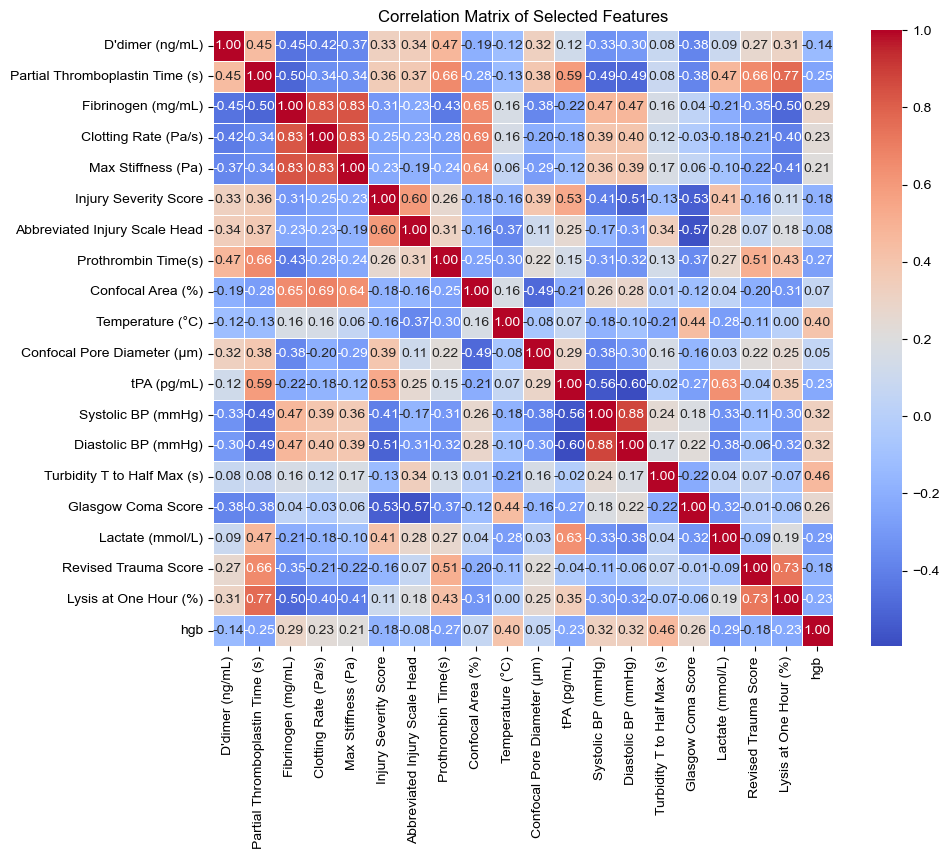

In [8]:
# Get the selected features from the feature importance DataFrame
selected_features = feature_importance_df_selected['Feature']

# Extract the corresponding columns from the original data
selected_features_data = X_train[selected_features]

# Calculate the correlation matrix
correlation_matrix = selected_features_data.corr()

# Print or visualize the correlation matrix
# print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()



In [11]:
warnings.filters("ignore")
# Set a threshold for correlation
correlation_threshold = 0.7  # Adjust as needed

# Find highly correlated features
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

# Remove highly correlated features from the selected features
selected_features_final = [feature for feature in selected_features if feature not in highly_correlated_features]

# Extract the corresponding columns from the original data
X_train_final = X_train[selected_features_final]
X_test_final = X_test[selected_features_final]

# Train Random Forest on the final set of features
clf_final = RandomForestClassifier(
    n_estimators=100,          # Adjust parameters as needed
    max_features='sqrt',
    bootstrap=True,
    random_state=2,
    oob_score=True,
    n_jobs=10
)

# Fit the model
clf_final.fit(X_train_final, y_train)

# Predict on the test set
y_pred_final = clf_final.predict(X_test_final)

# Evaluate the model
# evaluate_model(clf_final, 'Random Forest Uncorrelated',clf_final.get_params(), X_train_final, y_train, X_test_final, y_test,5,"../results/result_metrics.csv")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [14]:
len(X_train_final.iloc[0,:])

16

In [19]:
highly_correlated_features

{'Clotting Rate (Pa/s)',
 'Diastolic BP (mmHg)',
 'Lysis at One Hour (%)',
 'Max Stiffness (Pa)'}

In [18]:
# Work later on this. This code is used to find the correlation between highly correlated 
# features.
# # Calculate the correlation matrix
# correlation_matrix = X_train_selected[list(highly_correlated_features)].corr()

# # Print or visualize the correlation matrix
# # print(correlation_matrix)
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plot a heatmap of the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix of highly_correlated_features')
# plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### 

#### RF avoid overfitting n=150

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Original feature selection
num_features = 20
rfe = RFE(estimator=RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=10), n_features_to_select=num_features)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_test_selected = rfe.transform(X_test)

# Updated Random Forest model
clf_rf_150 = RandomForestClassifier(
    n_estimators=150,          # Reduced number of trees
    max_features='sqrt',       # Automatically consider sqrt(number of features) features at each split
    bootstrap=True,
    random_state=1,
    oob_score=True,
    n_jobs=10
)

# Train the updated model on the reduced set of features
clf_rf_150.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_rf_updated = clf_rf_150.predict(X_test_selected)

# Evaluate the updated model
accuracy_rf_updated = accuracy_score(y_test, y_pred_rf_updated)
print(f'Test Accuracy with Updated Random Forest: {accuracy_rf_updated:.4f}')

# Cross-validation scores with the updated model
cv_scores_rf_updated = cross_val_score(clf_rf_150, X_train_selected, y_train, cv=5)
print('Cross-Validation Scores:', cv_scores_rf_updated)
print(f'Mean CV Score: {cv_scores_rf_updated.mean()}')

# Confusion matrix
cm_rf_updated = confusion_matrix(y_test, y_pred_rf_updated)
print('Confusion Matrix:')
print(cm_rf_updated)

# Classification report
classification_rep_rf_updated = classification_report(y_test, y_pred_rf_updated)
print('Classification Report:')
print(classification_rep_rf_updated)


Test Accuracy with Updated Random Forest: 0.8462
Cross-Validation Scores: [0.625      0.875      0.85714286 1.         0.85714286]
Mean CV Score: 0.8428571428571429
Confusion Matrix:
[[18  1]
 [ 3  4]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        19
         1.0       0.80      0.57      0.67         7

    accuracy                           0.85        26
   macro avg       0.83      0.76      0.78        26
weighted avg       0.84      0.85      0.84        26



In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Original feature selection
num_features = 20
rfe = RFE(estimator=RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=10), n_features_to_select=num_features)
X_train_selected = rfe.fit_transform(X_train, y_train)
X_test_selected = rfe.transform(X_test)

# Updated Random Forest model
clf_rf_200 = RandomForestClassifier(
    n_estimators=100,          # Reduced number of trees
    max_features='sqrt',       # Automatically consider sqrt(number of features) features at each split
    bootstrap=True,
    random_state=1,
    oob_score=True,
    n_jobs=10
)

# Train the updated model on the reduced set of features
clf_rf_200.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_rf_updated = clf_rf_200.predict(X_test_selected)

# Evaluate the updated model
accuracy_rf_updated = accuracy_score(y_test, y_pred_rf_updated)
print(f'Test Accuracy with Updated Random Forest: {accuracy_rf_updated:.4f}')

# Cross-validation scores with the updated model
cv_scores_rf_updated = cross_val_score(clf_rf_200, X_train_selected, y_train, cv=5)
print('Cross-Validation Scores:', cv_scores_rf_updated)
print(f'Mean CV Score: {cv_scores_rf_updated.mean()}')

# Confusion matrix
cm_rf_updated = confusion_matrix(y_test, y_pred_rf_updated)
print('Confusion Matrix:')
print(cm_rf_updated)

# Classification report
classification_rep_rf_updated = classification_report(y_test, y_pred_rf_updated)
print('Classification Report:')
print(classification_rep_rf_updated)


Test Accuracy with Updated Random Forest: 0.8462
Cross-Validation Scores: [0.625      0.875      0.85714286 1.         0.71428571]
Mean CV Score: 0.8142857142857143
Confusion Matrix:
[[18  1]
 [ 3  4]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        19
         1.0       0.80      0.57      0.67         7

    accuracy                           0.85        26
   macro avg       0.83      0.76      0.78        26
weighted avg       0.84      0.85      0.84        26



#### ROC AUC Curve

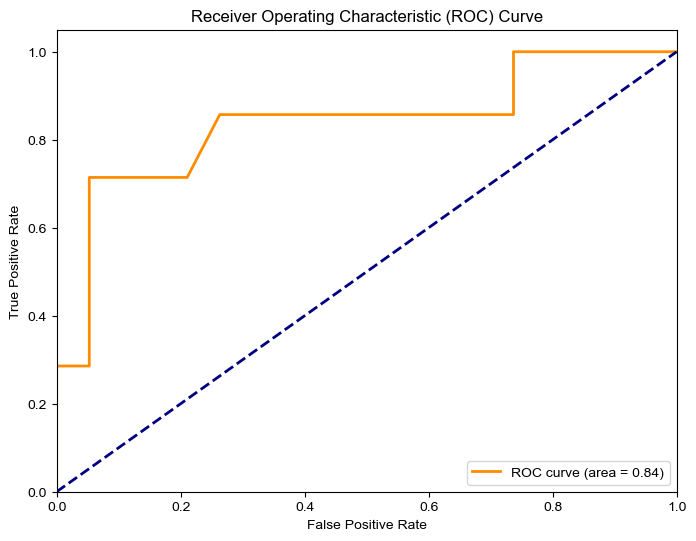

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# https://www.youtube.com/watch?v=4jRBRDbJemM
# Compute the probability estimates of the positive class
# y_prob = clf_2.predict_proba(X_test)[:, 1]
y_prob = clf_2_selected.predict_proba(X_test_selected)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#### PR Curve

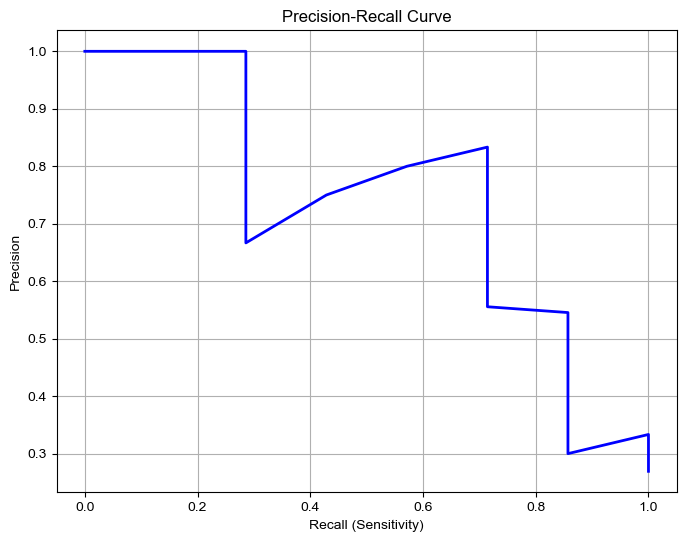

In [53]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision and recall for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


#### Calibration Curve

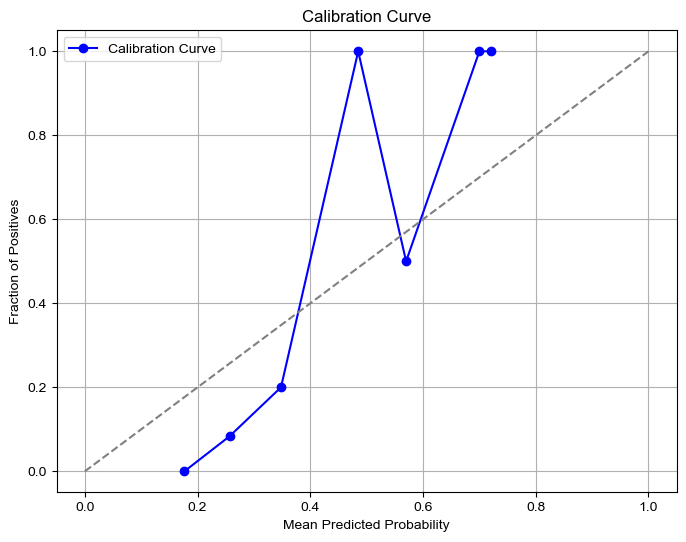

In [54]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute the true probabilities and predicted probabilities
true_probs, pred_probs = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(pred_probs, true_probs, marker='o', color='blue', label='Calibration Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid()
plt.legend()
plt.show()


#### Lift Curve

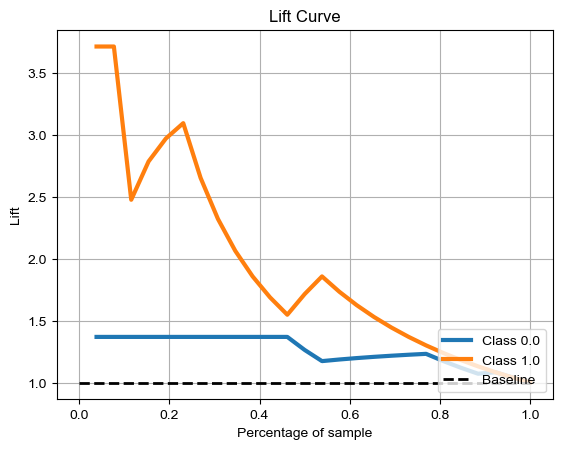

In [55]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# Assuming you have already fitted a model and obtained predicted probabilities
# clf_2.fit(X_train, y_train)
y_prob = clf_2.predict_proba(X_test)

# Create the lift curve
skplt.metrics.plot_lift_curve(y_test, y_prob)
plt.title('Lift Curve')
plt.show()


#### Feature Importance Plot

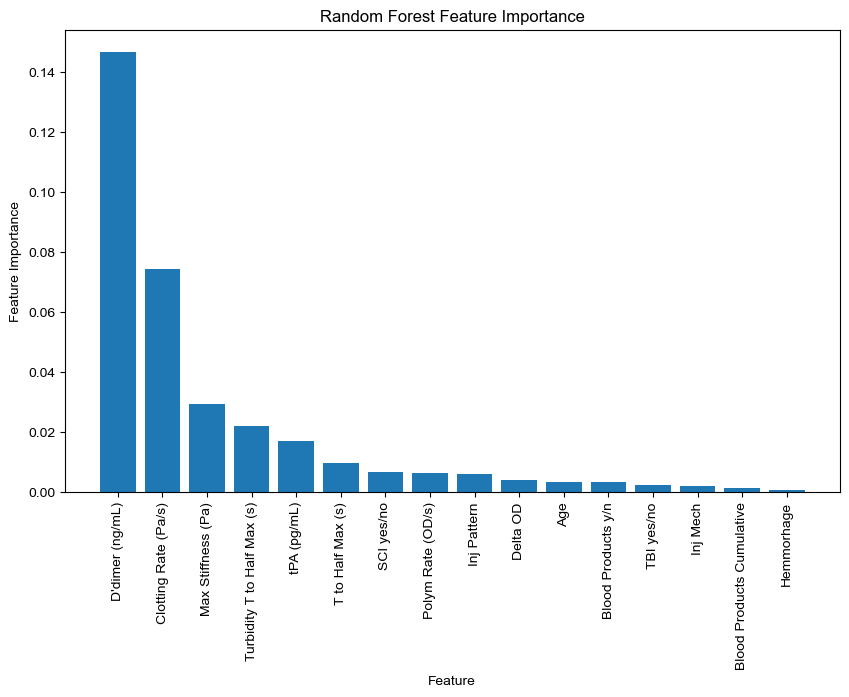

In [56]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Assuming you have already fitted a random forest classifier
# clf_2.fit(X_train, y_train)

# Get feature importances
feature_importances = clf_2.feature_importances_[:16]
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


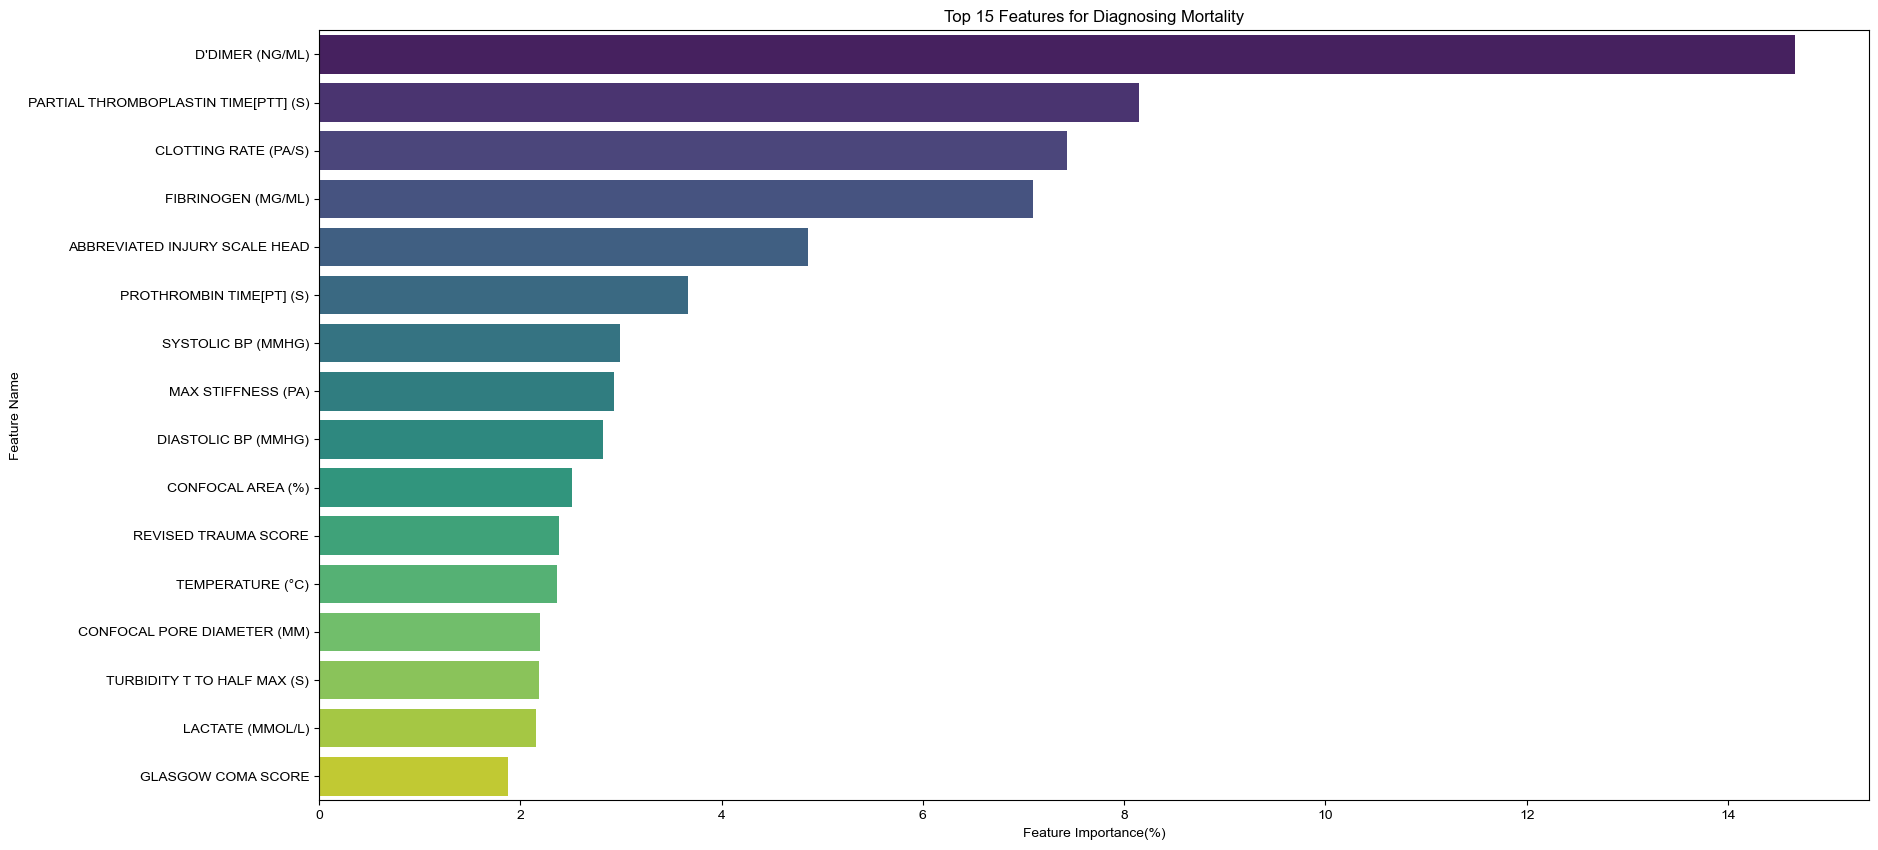

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature names and importance scores
top_features=sorted_feature_importances_main[:16]
feature_names = [x[0].upper() for x in top_features]
importance_scores = [x[1]*100 for x in top_features]

plt.figure(figsize=(20, 10))
sns.barplot(x=importance_scores, y=feature_names, orient="h", palette="viridis")
# Customize the plot
plt.xlabel("Feature Importance(%)")
plt.ylabel("Feature Name")
plt.title("Top 15 Features for Diagnosing Mortality")

# Show the plot
plt.show()

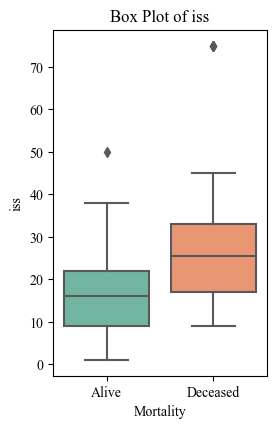

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of top features you want to visualize
num_top_features = 5  # Change this to the number of top features you want to visualize

# Extract the names of the most important features from the sorted list
top_feature_names = [feature for feature, _ in sorted_feature_importances_main[:num_top_features]]
top_feature_names=['iss']
# Create box plots for the top features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_feature_names):
    plt.subplot(2, num_top_features, i + 1)
    boxplot=sns.boxplot(x=df['Mortality'], y=df[feature], palette='Set2')
    plt.title(f'Box Plot of {feature}')
    plt.xlabel('Mortality')
    plt.ylabel(feature)
# Change x-axis tick labels
    boxplot.set_xticklabels(['Alive', 'Deceased'])
plt.tight_layout()
plt.show()


#### Swarm Plot

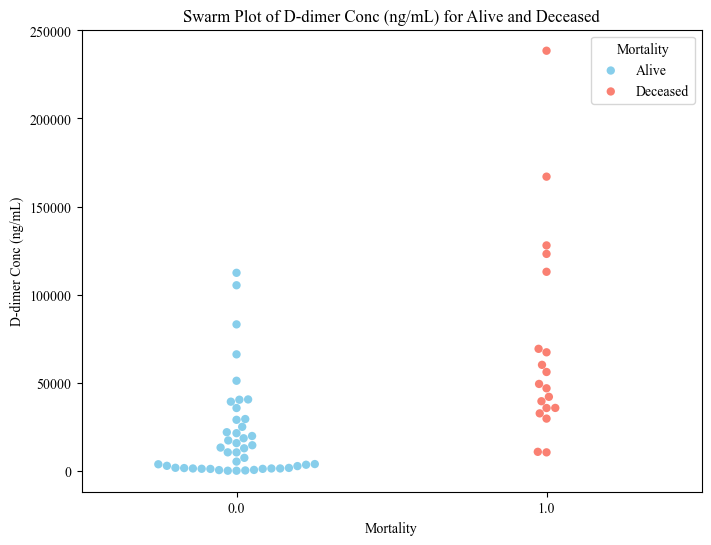

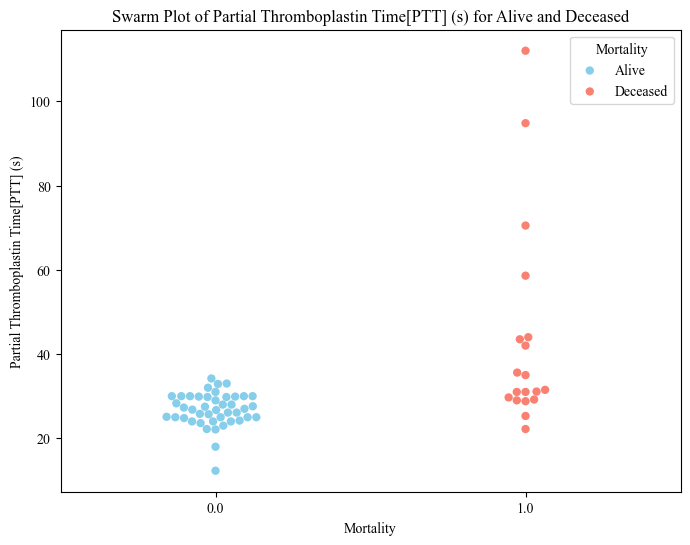

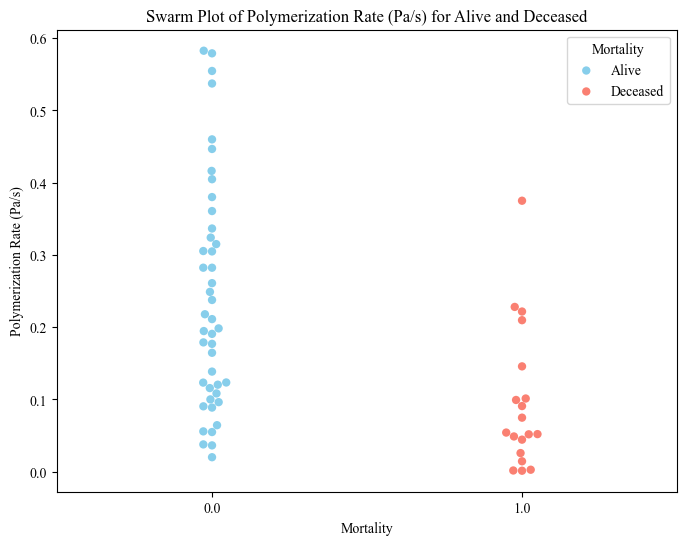

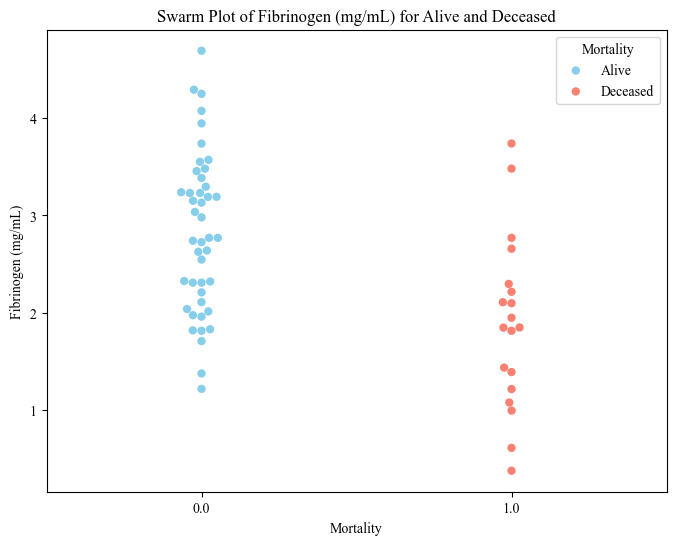

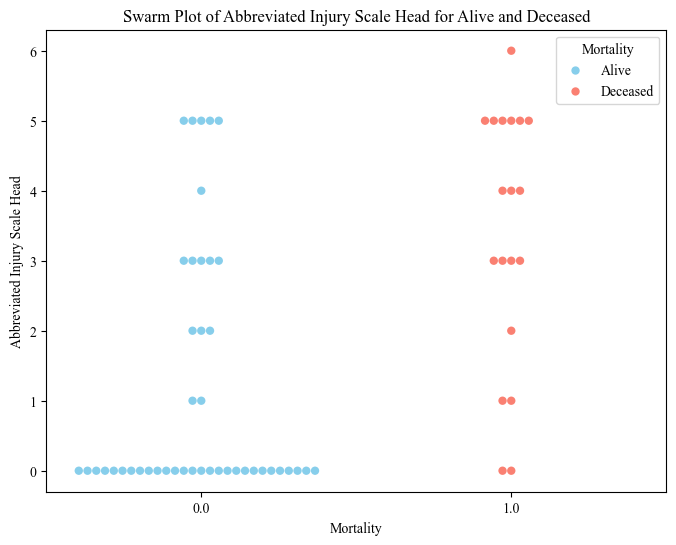

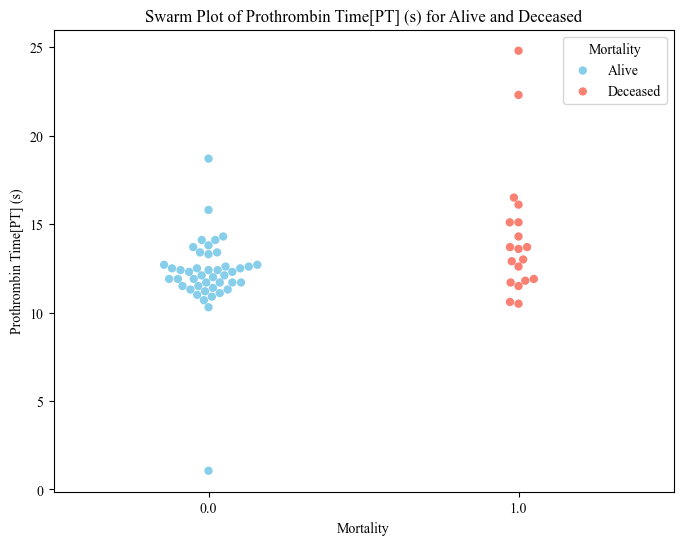

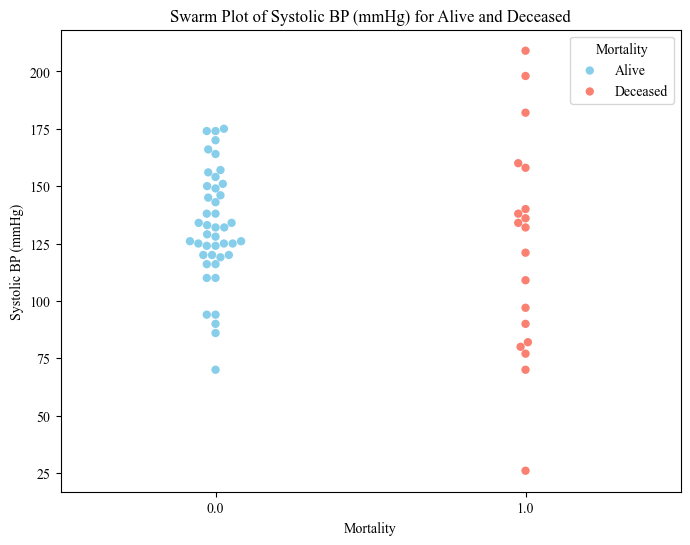

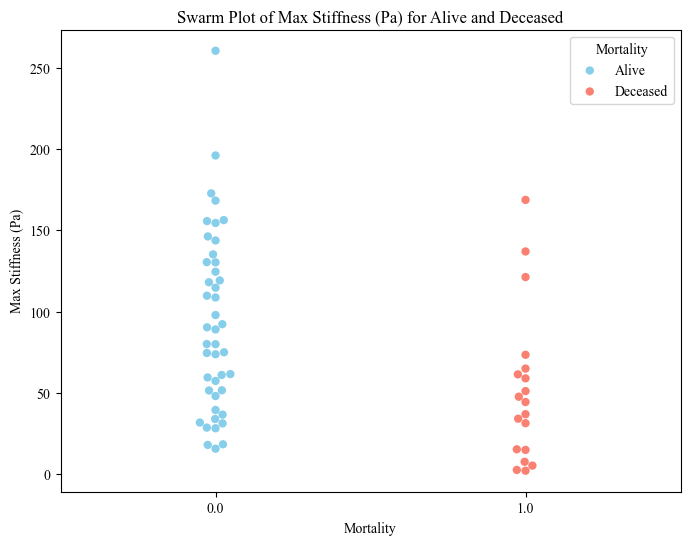

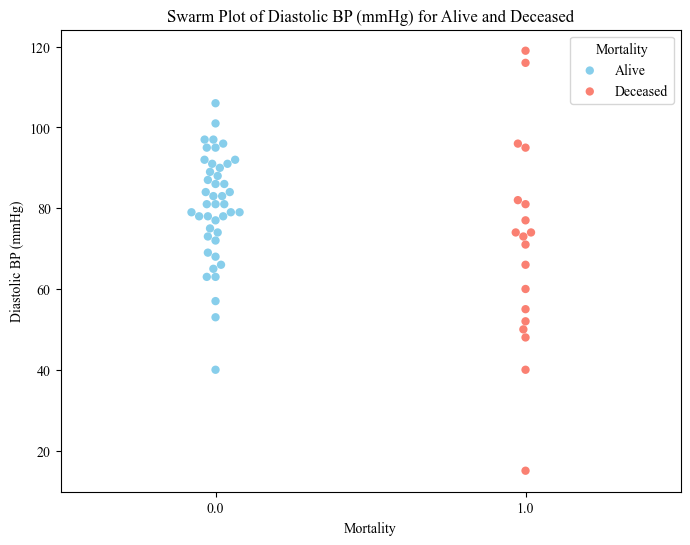

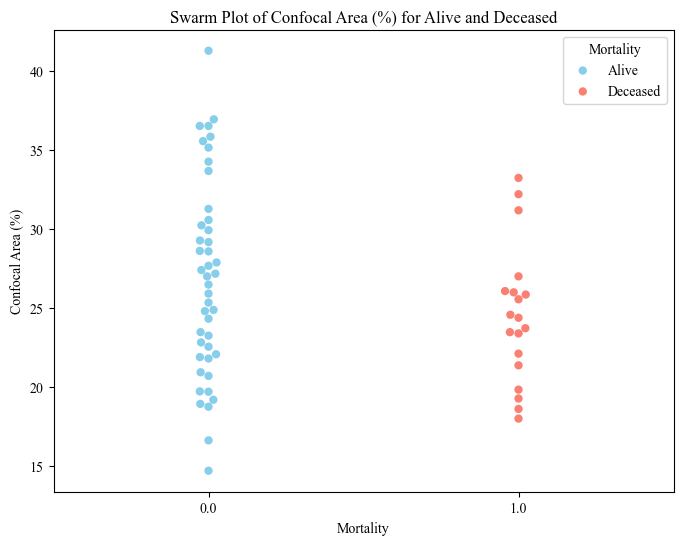

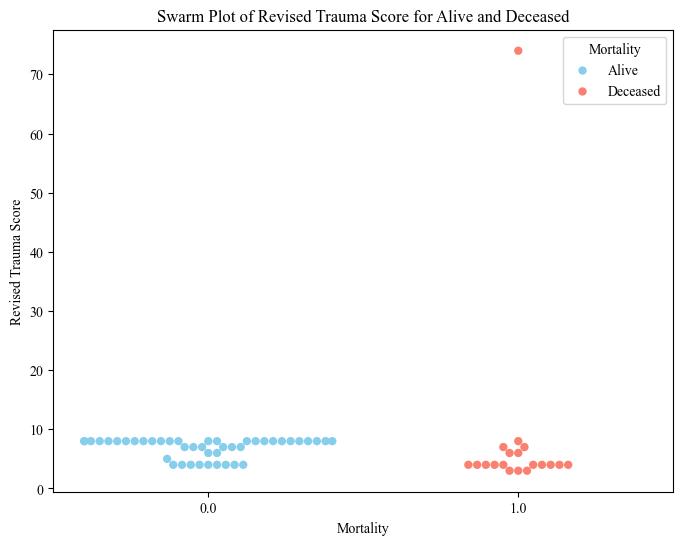

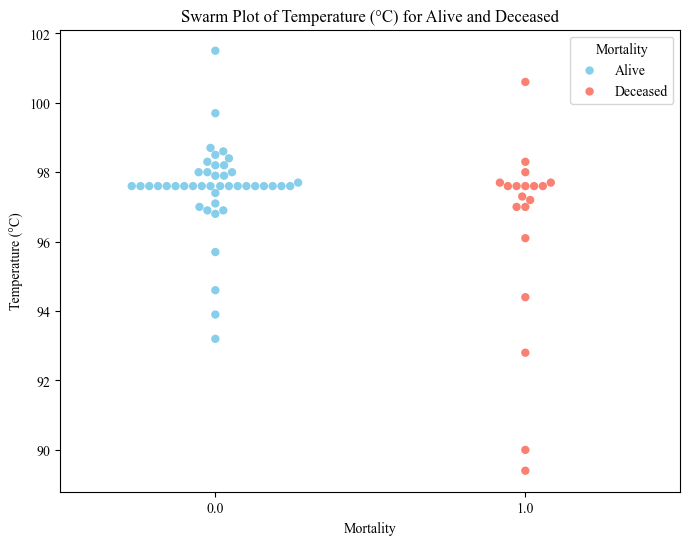

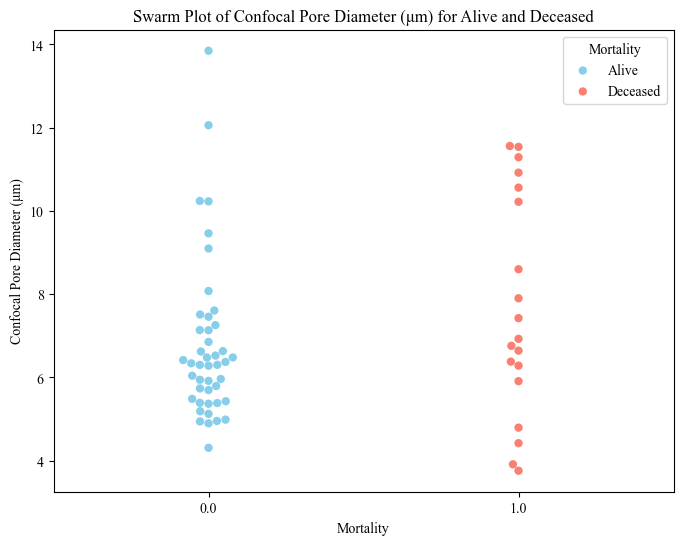

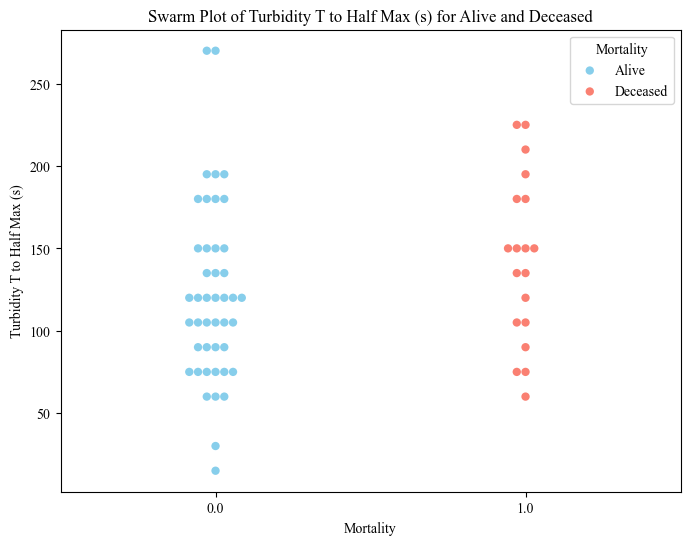

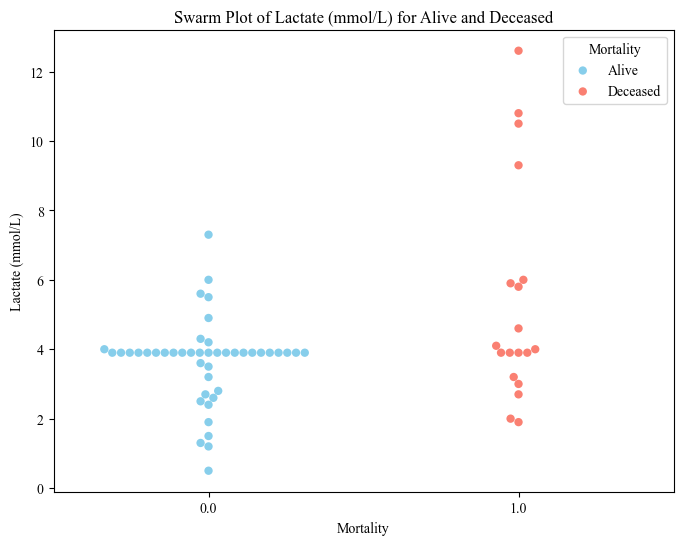

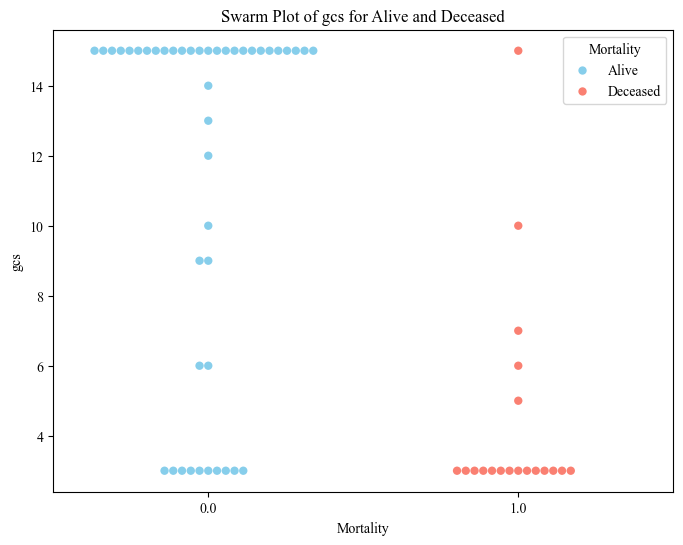

In [ ]:
#Swarm Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of top features you want to visualize
num_top_features = 16  # Change this to the number of top features you want to visualize

# Extract the names of the most important features from the sorted list
top_feature_names = [feature for feature, _ in sorted_feature_importances_main[:num_top_features]]

# Create a single swarm plot for all top features
for feature in top_feature_names:
    plt.figure(figsize=(8, 6))
    
    # Create a swarm plot with "Mortality" (0 and 1) as the hue to distinguish between classes
    sns.swarmplot(x='Mortality', y=feature, data=df, hue='Mortality', palette=['skyblue', 'salmon'], size=6)
    
    plt.title(f'Swarm Plot of {feature} for Alive and Deceased')
    plt.xlabel('Mortality')
    plt.ylabel(feature)
    plt.legend(title='Mortality', labels=['Alive', 'Deceased'])
    
    plt.show()


#### Density Plot

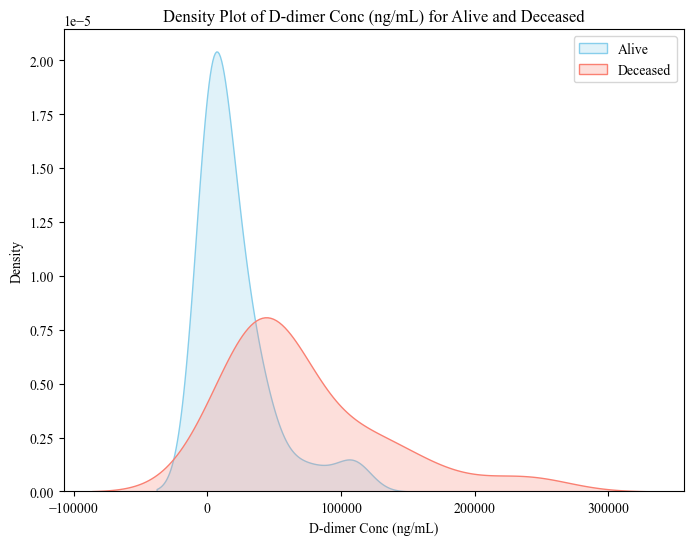

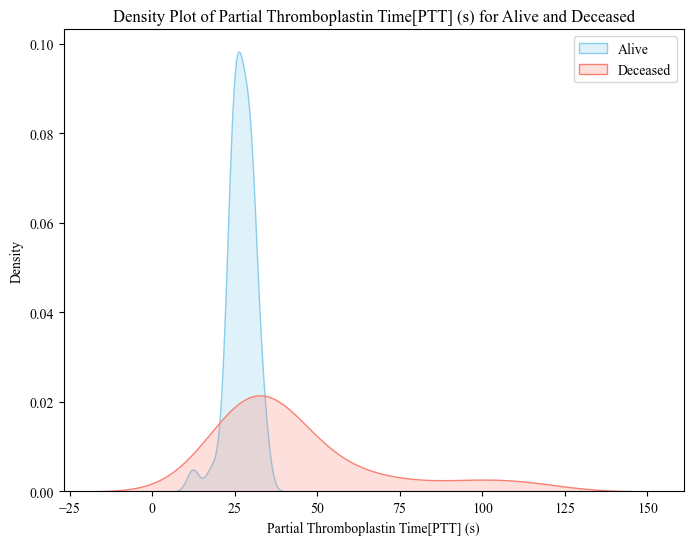

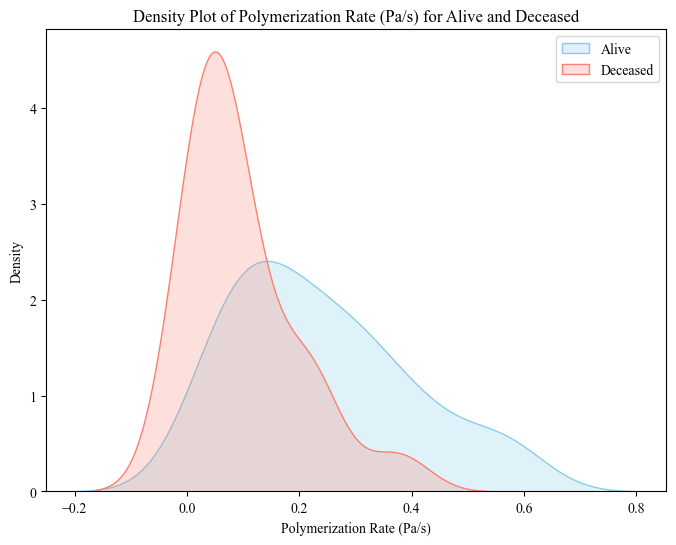

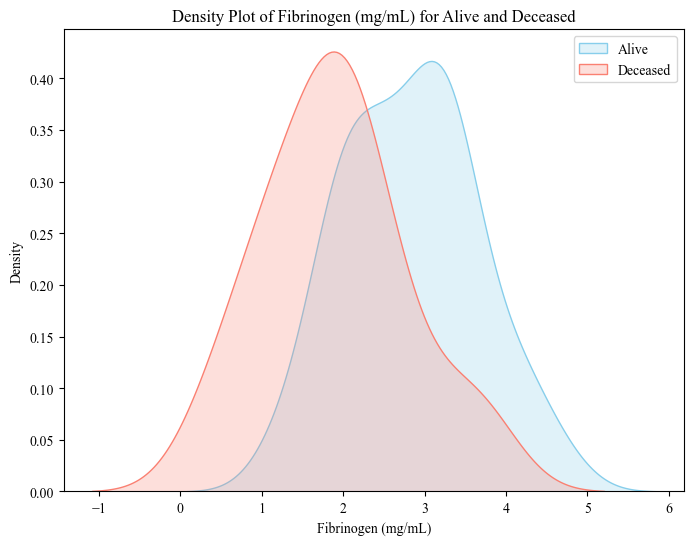

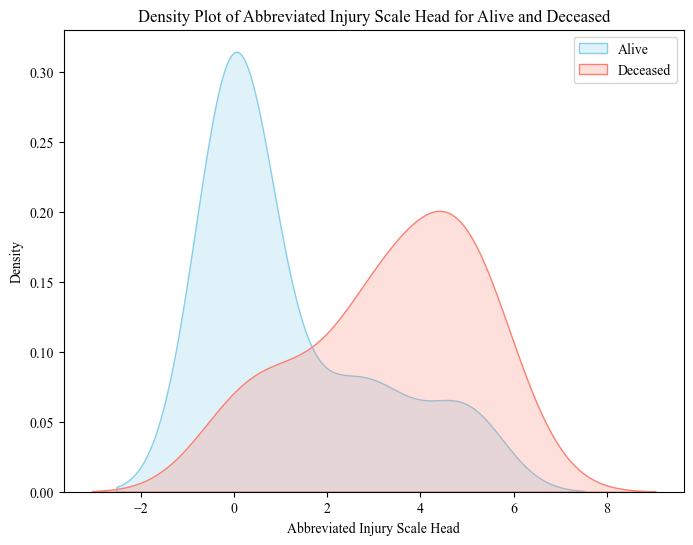

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of top features you want to visualize
num_top_features = 5  # Change this to the number of top features you want to visualize

# Extract the names of the most important features from the sorted list
top_feature_names = [feature for feature, _ in sorted_feature_importances_main[:num_top_features]]
# top_feature_names+=['iss']
# Create density plots for the top features
for feature in top_feature_names:
    plt.figure(figsize=(8, 6))
    
    # Create a density plot for "Alive" individuals
    sns.kdeplot(df[df['Mortality'] == 0][feature], label='Alive', color='skyblue', shade=True)
    
    # Create a density plot for "Deceased" individuals
    sns.kdeplot(df[df['Mortality'] == 1][feature], label='Deceased', color='salmon', shade=True)
    
    plt.title(f'Density Plot of {feature} for Alive and Deceased')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    
    plt.show()


#### Box Plot

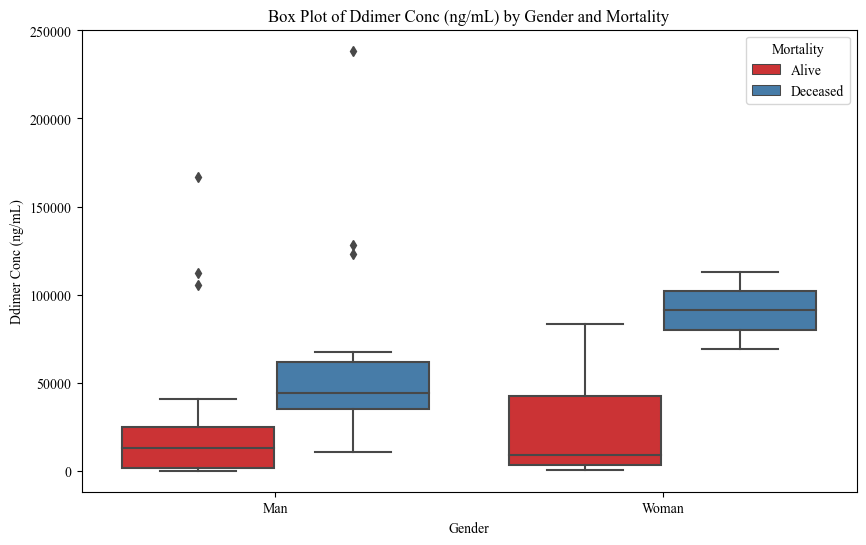

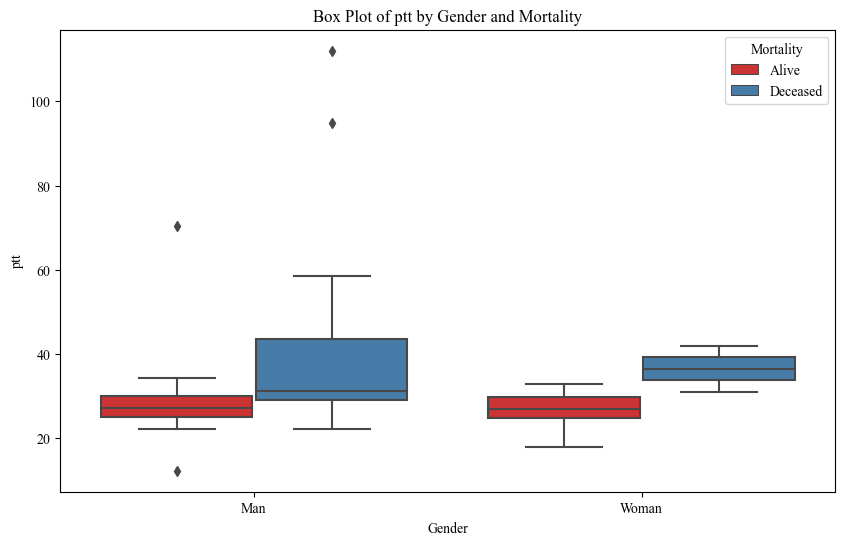

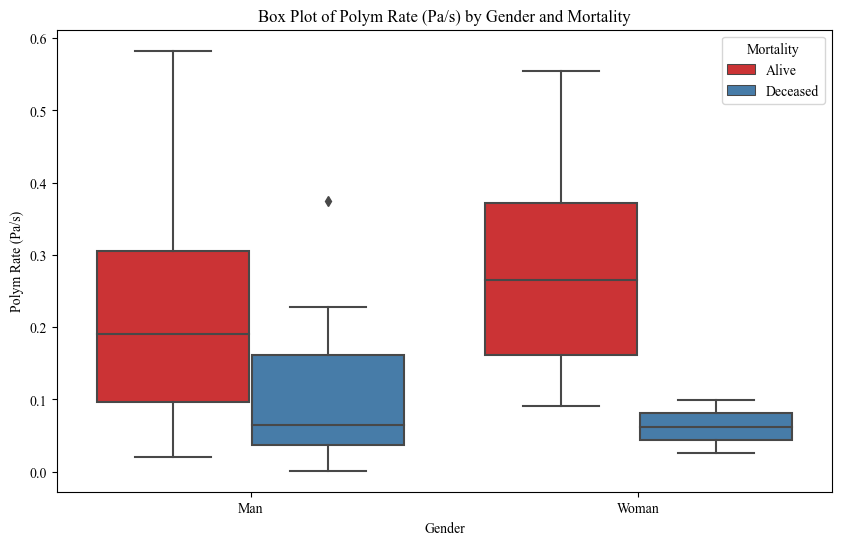

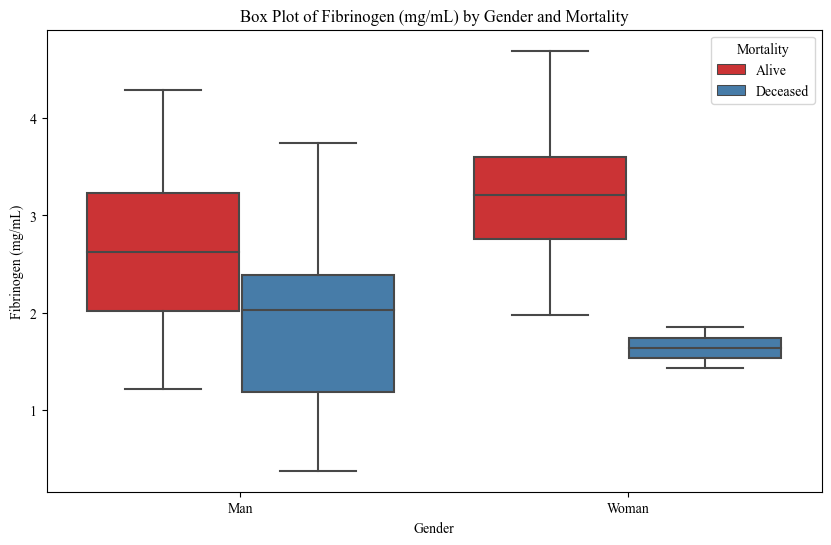

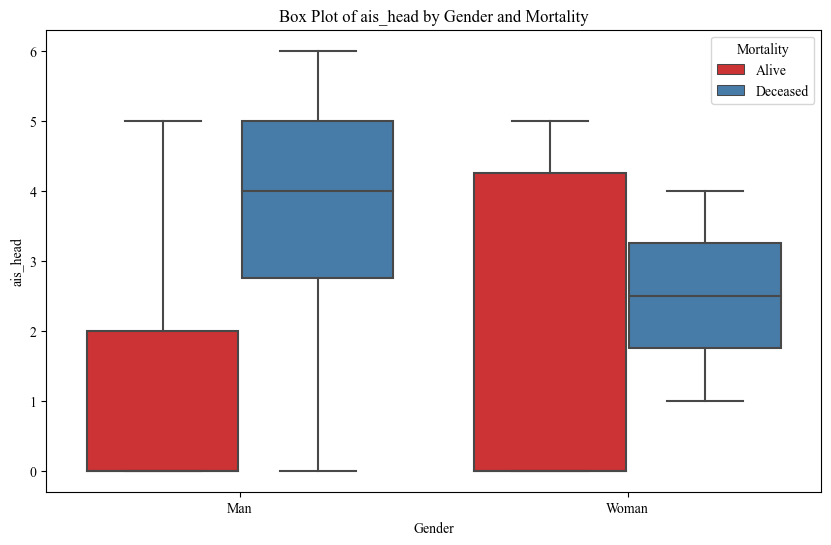

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of top features you want to visualize
num_top_features = 5  # Change this to the number of top features you want to visualize

# Extract the names of the most important features from the sorted list
top_feature_names = [feature for feature, _ in sorted_feature_importances_main[:num_top_features]]

# Create a loop to generate box plots for each feature
for feature in top_feature_names:
    plt.figure(figsize=(10, 6))
    
    # Create a box plot that separates data by gender (assuming you have a 'Gender' column)
    # boxplot=sns.boxplot(x='sex', y=feature, hue='Mortality', data=df,palette={0: 'skyblue', 1: 'salmon'})
    boxplot=sns.boxplot(x='sex', y=feature, hue='Mortality', data=df,palette="Set1")
    boxplot.set_xticklabels(['Man', 'Woman'])
    
    # Customize the plot
    plt.title(f'Box Plot of {feature} by Gender and Mortality')
    plt.xlabel('Gender')
    plt.ylabel(feature)
    legend=plt.legend()
    legend.set_title("Mortality")
    legend.texts[0].set_text("Alive")
    legend.texts[1].set_text("Deceased")
    # plt.legend([0,1],['Alive', 'Deceased'])
    # plt.legend(title='Mortality', labels=['Alive', 'Deceased'])
    # Create a custom legend with color rectangles and labels
    # legend_labels = ['Alive', 'Deceased']
    # legend_handles = [plt.Rectangle((0,0), 1, 1, color=custom_colors[label]) for label in legend_labels]
    # plt.legend(legend_handles, legend_labels, title='Mortality')
    # Show the plot
    plt.show()


In [ ]:
print(sorted_feature_importances_main)

[('D-dimer Conc (ng/mL)', 0.14666484663414928), ('Partial Thromboplastin Time[PTT] (s)', 0.0814309859513182), ('Polymerization Rate (Pa/s)', 0.0742887505771611), ('Fibrinogen (mg/mL)', 0.0709629076648701), ('Abbreviated Injury Scale Head', 0.0485860904592583), ('Prothrombin Time[PT] (s)', 0.0366507672794247), ('Systolic BP (mmHg)', 0.029870819907427598), ('Max Stiffness (Pa)', 0.02933274350681462), ('Diastolic BP (mmHg)', 0.028206522164868946), ('Confocal Area (%)', 0.025183204442505772), ('Revised Trauma Score', 0.023847728528320487), ('Temperature (°C)', 0.0236209045592938), ('Confocal Pore Diameter (μm)', 0.021923254130381938), ('Turbidity T to Half Max (s)', 0.021898979742778553), ('Lactate (mmol/L)', 0.021570449597181178), ('gcs', 0.018812743334990285), ('Lysis (%)', 0.01782465463935451), ('tPA Conc (pg/mL)', 0.017049570883064434), ('Injury Severity Score[ISS]', 0.016025659235191815), ('Velocity Index', 0.01348265669913196), ('inr', 0.013460381506202193), ('base', 0.01277285516693

#### Pie Chart

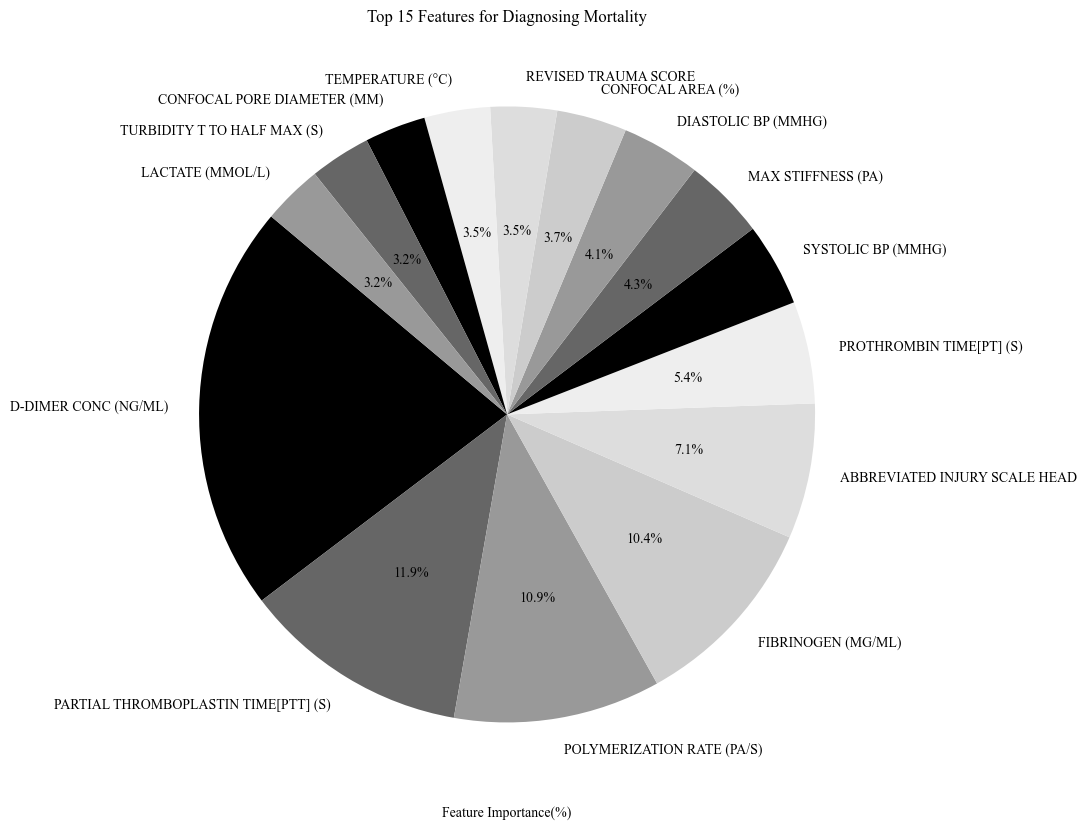

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature names and importance scores
top_features=sorted_feature_importances_main[:15]
feature_names = [x[0].upper() for x in top_features]
importance_scores = [x[1]*100 for x in top_features]
# Define a grayscale color map
cmap = plt.get_cmap('gray')
grayscale_colors = ['#000000', '#666666', '#999999', '#cccccc', '#dddddd', '#eeeeee']
plt.figure(figsize=(20, 10))
# sns.barplot(x=importance_scores, y=feature_names, orient="h", palette="viridis")
plt.pie(importance_scores, labels=feature_names, autopct='%1.1f%%', startangle=140,colors=grayscale_colors)
# Customize the plot
plt.xlabel("Feature Importance(%)")
# plt.ylabel("Feature Name")
plt.title("Top 15 Features for Diagnosing Mortality")

# Show the plot
plt.show()


In [80]:
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier

# def permutation_importance(model, X_test, y_test, n_repeats=100):
#   """Calculates permutation importance for a random forest classifier on the test set.

#   Args:
#     model: A trained random forest classifier.
#     X_test: The test data.
#     y_test: The target variable for the test data.
#     n_repeats: The number of times to repeat the permutation importance calculation.

#   Returns:
#     A list of permutation importance scores for each feature.
#   """

#   importance_scores = []
#   for i in range(X_test.shape[1]):
#     # Permute the values of the current feature in the test data.
#     X_test_permuted = X_test.copy()
#     np.random.shuffle(X_test_permuted.iloc[:, i].values)
#       # Check the shape of the current feature.
#     # if X_test_permuted[:, i].shape[0] < 2:
#     #   continue

#     # Permute the values of the current feature in the test data.
#     # X_test_permuted[:, i] = np.random.shuffle(X_test_permuted[:, i])
#     # Make predictions on the permuted test data.
#     y_pred_permuted = model.predict(X_test_permuted)

#     # Calculate the decrease in model performance.
#     accuracy_original = model.score(X_test, y_test)
#     accuracy_permuted = model.score(X_test_permuted, y_test)
#     importance_score = accuracy_original - accuracy_permuted
#     importance_scores.append(importance_score)

#   # Calculate the p-value for each importance score.
#   p_values = np.zeros(len(importance_scores))
#   for i in range(len(importance_scores)):
#     importance_score_permuted = np.random.choice(importance_scores, size=n_repeats)
#     p_values[i] = np.sum(importance_score_permuted >= importance_scores[i]) / n_repeats

#   return importance_scores, p_values


In [ ]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
np.random.shuffle(df.iloc[:,0].values)
print(df)

   A  B
0  3  4
1  2  5
2  1  6


In [ ]:
importance_scores, p_values = permutation_importance(clf_2, X_test, y_test)


In [ ]:
for i in range(len(importance_scores)):
    print(importance_scores[i],":",p_values[i])
# print(importance_scores)
# print(p_values)

0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.07692307692307687 : 0.02
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.038461538461538436 : 0.09
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.038461538461538436 : 0.09
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.038461538461538436 : 0.08
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.11538461538461542 : 0.03
0.11538461538461542 : 0.02
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.038461538461538436 : 0.12
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1.0
0.0 : 1

#### RF 4

In [81]:
top_features=[]
n_feature=16
i=0
for feature in sorted_feature_importances_main:
    i+=1
    top_features.append(feature[0])
    if i==n_feature:
        break
print(len(top_features))
X_top=X.loc[:,top_features]
# print(X_top.head(1))


16


In [82]:
from sklearn.model_selection import train_test_split

X_top_train, X_top_test, y_train, y_test = train_test_split(X_top, y, test_size=0.4, random_state=1)
print("Train length",len(X_top_train))
print("Test length",len(X_top_test))

Train length 37
Test length 26


Accuracy: 0.73
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81        19
         1.0       0.50      0.57      0.53         7

    accuracy                           0.73        26
   macro avg       0.67      0.68      0.67        26
weighted avg       0.74      0.73      0.74        26



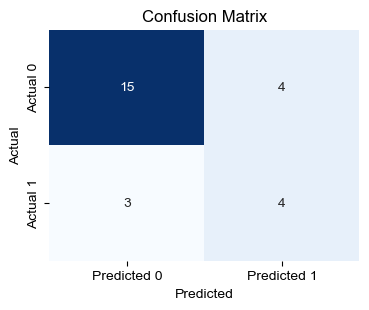

In [83]:
#Random Forest with hyper parameter
clf_4 = RandomForestClassifier(
    n_estimators=200,          # Number of trees in the forest
    max_features=20,       # Number of features to consider at each split
    bootstrap=True,            # Whether to use bootstrapped samples
    random_state=1,            # Random seed for reproducibility
    oob_score=True,
    n_jobs=10,
    # verbose=2
)

# Fit the classifier to your training data
clf_4.fit(X_top_train, y_train)

y_pred_4 = clf_4.predict(X_top_test)
acc = accuracy_score(y_test, y_pred_4)
print(f'Accuracy: {acc:.2f}')
print(classification_report(y_test, y_pred_4))
cm=(confusion_matrix(y_test, y_pred_4))

import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [64]:
# Getting feature importances
feature_importances = clf_4.feature_importances_

# Matching feature importances with feature names
feature_names = X_top.columns  # Replacing with the actual feature names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sorting feature importances by importance score
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Printing the sorted feature importances
# s=0
for feature, importance in sorted_feature_importances:
    # print(f"{feature}: \t\t\t{importance*100:.4f}")
    # s+=importance
    print(f"{importance*100:.4f} %\t:\t{feature}")

38.6850 %	:	D'dimer (ng/mL)
8.9191 %	:	Partial Thromboplastin Time[PTT] (s)
8.5160 %	:	Confocal Area (%)
7.8258 %	:	Fibrinogen (mg/mL)
7.1625 %	:	Abbreviated Injury Scale Head
5.5286 %	:	Prothrombin Time[PT] (s)
4.9607 %	:	Clotting Rate (Pa/s)
2.6808 %	:	Confocal Pore Diameter (μm)
2.6202 %	:	Lactate (mmol/L)
2.5788 %	:	Diastolic BP (mmHg)
2.3916 %	:	Temperature (°C)
2.3352 %	:	Turbidity T to Half Max (s)
1.7459 %	:	Glasgow Coma Score
1.4684 %	:	Max Stiffness (Pa)
1.4375 %	:	Systolic BP (mmHg)
1.1439 %	:	Revised Trauma Score


#### RF 3

Accuracy: 0.88
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92        19
         1.0       0.83      0.71      0.77         7

    accuracy                           0.88        26
   macro avg       0.87      0.83      0.85        26
weighted avg       0.88      0.88      0.88        26



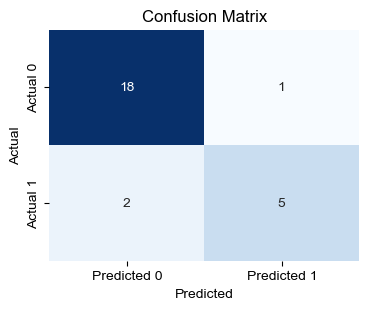

In [65]:
# Best Hyperparameters:
# {'bootstrap': True, 'max_depth': None, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
#Random Forest with hyper parameter
clf_3 = RandomForestClassifier(
    n_estimators=200,          # Number of trees in the forest
    max_features=20,       # Number of features to consider at each split
    bootstrap=True,            # Whether to use bootstrapped samples
    random_state=1,            # Random seed for reproducibility
    oob_score=True,
    min_samples_leaf=1,
    min_samples_split=10,
    # n_jobs=10,
    # verbose=2
)

# Fit the classifier to your training data
clf_3.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_3 = clf_3.predict(X_test)
acc = accuracy_score(y_test, y_pred_3)
print(f'Accuracy: {acc:.2f}')
print(classification_report(y_test, y_pred_3))
cm=(confusion_matrix(y_test, y_pred_3))

import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameter grid to search
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
#     'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
#     'min_samples_leaf': [1, 2, 4],  # Minimum samples required in a leaf node
#     'max_features': ['auto', 'sqrt', 'log2',20],  # Number of features to consider at each split
#     'bootstrap': [True, False],  # Whether to use bootstrapped samples
# }

# # Create a Random Forest classifier
# clf = RandomForestClassifier(random_state=42)

# # Create GridSearchCV with 5-fold cross-validation
# grid_search = GridSearchCV(estimator=clf_2, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# # Fit the grid search to your training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters found
# print("Best Hyperparameters:")
# print(grid_search.best_params_)

# # Get the best model with the optimal hyperparameters
# best_model = grid_search.best_estimator_

# # Evaluate the best model on the test set
# y_pred = best_model.predict(X_test)


In [ ]:
# Best Hyperparameters:
# {'bootstrap': True, 'max_depth': None, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

## 2. Logistic Regression Classifier

In [85]:
from sklearn.linear_model import LogisticRegression
# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(C=1.0,penalty='l2',solver='liblinear',random_state=1)

# Train the model on the training data
logistic_regression.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.85
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89        19
         1.0       0.67      0.86      0.75         7

    accuracy                           0.85        26
   macro avg       0.80      0.85      0.82        26
weighted avg       0.87      0.85      0.85        26

[[16  3]
 [ 1  6]]


## 3. Support Vector Classifier

In [92]:
from sklearn.svm import SVC
# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42,probability=True)  # You can choose different kernels like 'rbf', 'poly', etc.

# Train the model on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.81
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86        19
         1.0       0.60      0.86      0.71         7

    accuracy                           0.81        26
   macro avg       0.77      0.82      0.78        26
weighted avg       0.85      0.81      0.82        26

[[15  4]
 [ 1  6]]


In [ ]:
from sklearn.svm import SVC
# Initialize the SVM classifier
svm_classifier = SVC(kernel='sigmoid', random_state=42)  # You can choose different kernels like 'rbf', 'poly', etc.

# Train the model on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.62
              precision    recall  f1-score   support

         0.0       0.85      0.58      0.69        19
         1.0       0.38      0.71      0.50         7

    accuracy                           0.62        26
   macro avg       0.62      0.65      0.59        26
weighted avg       0.72      0.62      0.64        26

[[11  8]
 [ 2  5]]


## 4. Neural Net Classifier

In [20]:
import tensorflow
import keras

2024-03-04 18:31:19.923922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Get the selected features from the feature importance DataFrame
selected_features = feature_importance_df_selected['Feature']

# Extract the corresponding columns from the original data
selected_features_data = X_train[selected_features]

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_temp, y_train, y_temp = train_test_split(X[selected_features], y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=1)

# Define a simple neural network model
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
# model.add(BatchNormalization())  # Add BatchNormalization
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())  # Add BatchNormalization
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())  # Add BatchNormalization
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
# model.add(BatchNormalization())  # Add BatchNormalization
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

 
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

# Set up early stopping to prevent overfitting
# early_stopping= EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# Train the model
epochs=300
batch_size=8
#1000,16=84.62 , no early stopping

# history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/300
5/5 [==============================] - 1s 34ms/step - loss: 2179.7119 - accuracy: 0.5405 - val_loss: 1329.1995 - val_accuracy: 0.2667
Epoch 2/300
5/5 [==============================] - 0s 7ms/step - loss: 1886.1609 - accuracy: 0.6486 - val_loss: 1296.3136 - val_accuracy: 0.2667
Epoch 3/300
5/5 [==============================] - 0s 7ms/step - loss: 2010.4176 - accuracy: 0.5135 - val_loss: 850.8866 - val_accuracy: 0.2000
Epoch 4/300
5/5 [==============================] - 0s 7ms/step - loss: 2252.3196 - accuracy: 0.4054 - val_loss: 680.9528 - val_accuracy: 0.6000
Epoch 5/300
5/5 [==============================] - 0s 7ms/step - loss: 623.1299 - accuracy: 0.4865 - val_loss: 344.7110 - val_accuracy: 0.6000
Epoch 6/300
5/5 [==============================] - 0s 7ms/step - loss: 761.3307 - accuracy: 0.6486 - val_loss: 43.6578 - val_accuracy: 0.6000
Epoch 7/300
5/5 [==============================] - 0s 7ms/step - loss: 553.2299 - accuracy: 0.5946 - val_loss: 19.4706 - val_accuracy: 0

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

# Define a function to create your Keras model
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
    return model

# Create a KerasClassifier
keras_model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=16, verbose=0)

# Evaluate the model using cross_val_score
cv_scores = cross_val_score(keras_model, X_train, y_train, cv=5)

# Print the mean CV score
print(f'Mean CV Score: {cv_scores.mean()}')


Mean CV Score: 0.5785714387893677


## 5. XG Boost

In [30]:
import xgboost as xgb


# Create an XGBoost classifier
clf_xgb = xgb.XGBClassifier(
    n_estimators=80,         # Number of boosting rounds (trees)
    max_depth=6,               # Maximum depth of a tree
    learning_rate=0.1,         # Step size shrinkage used in update to prevent overfitting
    subsample=0.8,             # Fraction of samples used for training each boosting round
    colsample_bytree=0.8,      # Fraction of features used for training each boosting round
    objective='binary:logistic',  # Binary classification objective
    random_state=1             # Random seed for reproducibility
)
# clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)
# Make predictions
y_pred_xgb = clf_xgb.predict(X_test)

# Evaluate the performance
#Accuracy Scores
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")
# Example of cross-validation
cv_scores = cross_val_score(clf_xgb, X_train, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores)}')
# Example of evaluating on a test set
test_acc = clf_xgb.score(X_test, y_test)
print(f'Test Accuracy: {test_acc}')
train_acc = clf_xgb.score(X_train, y_train)
print(f'Train Accuracy: {train_acc}')



Cross-Validation Scores: [0.625      0.875      0.71428571 0.85714286 0.71428571]
Mean CV Score: 0.7571428571428572
Test Accuracy: 0.8461538461538461
Train Accuracy: 1.0


### XGB Prediction

Accuracy: 0.85
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90        19
         1.0       0.80      0.57      0.67         7

    accuracy                           0.85        26
   macro avg       0.83      0.76      0.78        26
weighted avg       0.84      0.85      0.84        26



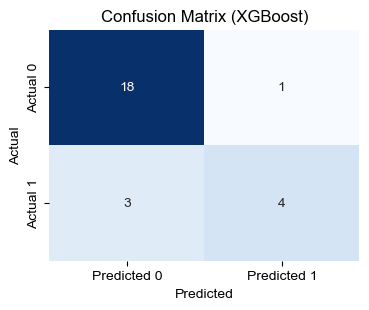

In [29]:

# Make predictions
y_pred_xgb = clf_xgb.predict(X_test)

# Evaluate the performance
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {acc_xgb:.2f}')
print(classification_report(y_test, y_pred_xgb))

# Create a confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()


# Evaluation Function

In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, matthews_corrcoef, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

def evaluate_model(model, model_name, model_params, X_train, y_train, X_test, y_test, num_cv_folds=5, results_file='results.csv'):
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predictions and predicted probabilities on the test data
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # For models with predict_proba support
    
    # Test Accuracy
    test_accuracy = accuracy_score(y_test, y_pred)

    # Cross-Validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=num_cv_folds)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Classification report
    classification_rep = classification_report(y_test, y_pred)

    # Sensitivity (Recall)
    sensitivity = recall_score(y_test, y_pred)

    # Specificity
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    # Sensitivity-Specificity Gap
    sensitivity_specificity_gap = sensitivity - (1 - specificity)

    # AUC (C-statistic)
    auc_score = roc_auc_score(y_test, y_prob)

    # Positive Predictive Value (Precision)
    ppv = precision_score(y_test, y_pred)

    # Negative Predictive Value
    npv = cm[1, 1] / (cm[1, 0] + cm[1, 1])

    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)

    # F1 Score
    f1 = f1_score(y_test, y_pred)

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Model Name': [model_name],
        'Train Accuracy': [round(model.score(X_train, y_train)*100,3)],
        'Test Accuracy': [round(test_accuracy*100,3)],
        'Mean CV Score': [round(cv_scores.mean()*100,3)],
        'Sensitivity': [round(sensitivity,3)],
        'Specificity': [round(specificity,3)],
        'Sensitivity-Specificity Gap': [round(sensitivity_specificity_gap,3)],
        'AUC': [round(auc_score,3)],
        'PPV': [round(ppv,3)],
        'NPV': [round(npv,3)],
        'MCC': [round(mcc,3)],
        'F1 Score': [round(f1,3)],
        'Model Parameters': [model_params]
    })

    # Append results to the CSV file
    # results_df.to_csv(results_file, mode='a', header=pd.read_csv(results_file).shape[0])
    results_df.to_csv(results_file, mode='a', header=not 'column_names', index=False)


# Evaluation

In [31]:
#Evaluating and storing results in results_metrics.csv file
# evaluate_model(clf_rf_updated, 'Random Forest Updated', clf_rf_updated.get_params(), X_train_selected, y_train, X_test_selected, y_test,5,"../results/result_metrics.csv")
# evaluate_model(clf_rf_150, 'Random Forest Updated 150', clf_rf_150.get_params(), X_train_selected, y_train, X_test_selected, y_test,5,"../results/result_metrics.csv")
# evaluate_model(clf_5, 'Random Forest 5 RFE', clf_5.get_params(), X_train_selected, y_train, X_test_selected, y_test,5,"../results/result_metrics.csv")
# evaluate_model(clf_3, 'Random Forest 3', clf_3.get_params(), X_train, y_train, X_test, y_test,5,"../results/result_metrics.csv")
# evaluate_model(clf_4, 'Random Forest 4', clf_4.get_params(), X_top_train, y_train, X_top_test, y_test,5,"../results/result_metrics.csv")
# evaluate_model(clf_2, 'Random Forest 2', clf_2.get_params(), X_train, y_train, X_test, y_test,5,"../results/result_metrics.csv")
# evaluate_model(logistic_regression, 'Logistic Regression', logistic_regression.get_params(), X_train, y_train, X_test, y_test,5,"../results/result_metrics.csv")
# evaluate_model(svm_classifier, 'Support Vector Classifier', svm_classifier.get_params(), X_train, y_train, X_test, y_test,5,"../results/result_metrics.csv")
evaluate_model(clf_xgb, 'Extreme Gradient Boosting', clf_xgb.get_params(), X_train, y_train, X_test, y_test,5,"../results/result_metrics.csv")
